# Portfolio Optimization

Adapted from: https://qiskit-community.github.io/qiskit-finance/tutorials/01_portfolio_optimization.html

We are given a set of $n$ assets $\{1, 2, ..., n\}$, each with an expected return $\mu_i$.
In this simplified model, we have a binary choice: either choose an asset of do not.
We wish to find the maximum return:
$$ \max_{x_i} \left( \sum_i \mu_i x_i \right) = \min_{x_i} \left( - \sum_i \mu_i x_i \right)$$
where $x_i \in \{0, 1\}$ indicates a decision:
- $x_i=1$ pick asset $i$
- $x_i=0$ don't pick asset $i$

However we also want to take risk into account, which can be done via the covariances between the assets $\sigma_{ij}$.
Thus we want to minimize the following cost function:
$$C(\{x_i\}) = - \sum_i \mu_i x_i  + q\sum_{ij} \sigma_{ij} x_i x_j$$
where $q$ is the risk factor. 

To understand this cost function note that:
- For $q=0$ we just pick the best assests based on expected return
- For $q>0$ we take volatility into account
- For $q >>0$ we pick the assets with low variance and negative covariance

For more on the portfolio model see [here](https://en.wikipedia.org/wiki/Modern_portfolio_theory).

In [1]:
# Import necessary packages
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import QAOAAnsatz
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.primitives import StatevectorEstimator
from qiskit.quantum_info import Statevector, Pauli, SparsePauliOp

from scipy.optimize import minimize

from datetime import datetime

## Create the Data
We will use randomly generated data using `RandomDataProvider`.
The number of assets `num_assets` will equal the number of qubits required in the quantum computation.

In [2]:
num_assets = 4

stocks = [("Company %i" % i) for i in range(1, 1+num_assets)]
data = RandomDataProvider(
    tickers=stocks,
    start=datetime(2016, 1, 1),
    end=datetime(2016, 3, 1),
    seed=4,
)
data.run()

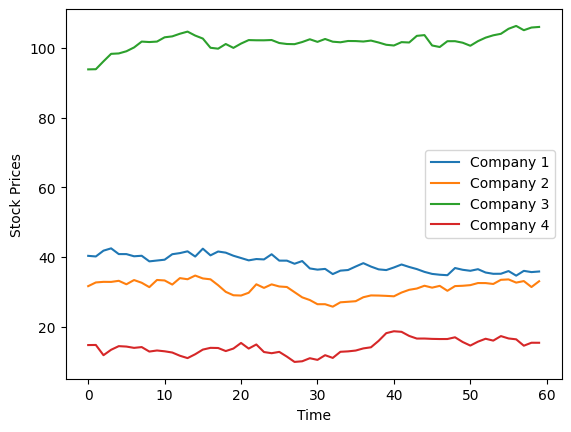

In [3]:
# Plot the stock prices
for (cnt, s) in enumerate(data._tickers):
    plt.plot(data._data[cnt], label=s)
plt.legend()
plt.ylabel("Stock Prices")
plt.xlabel("Time")
plt.show()

## Define Terms
If $p_i^{(t)}$ is the price at time $t$ for asset $i$ then define $d_i^{(t)}$ as the return at time $t$
$$ d_i^{(t)} = \frac{p_i^{(t+1)} - p_i^{(t)}}{p_i^{(t)}} $$

To compute $\mu_i$ we calculate the mean return over the whole period:
$$ \mu_i = \frac{1}{T} \sum_t d_i^{(t)} $$
and similarly for the covariance
$$ \sigma_{ij} = \frac{1}{T-2} \sum_t (d_i^{(t)} - \mu_i ) (d_j^{(t)} - \mu_j ) $$
where $T$ is the total number of timesteps.

In [4]:
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()

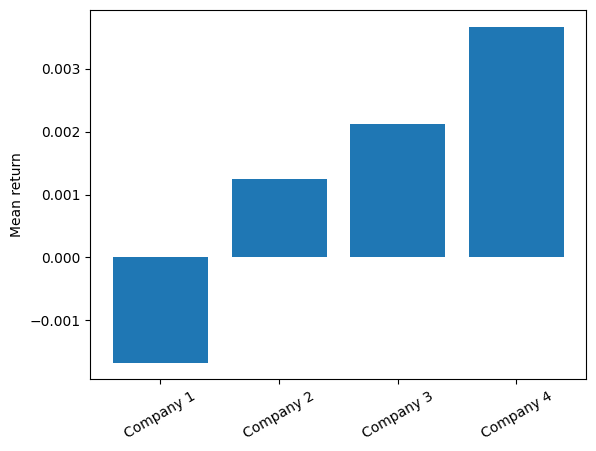

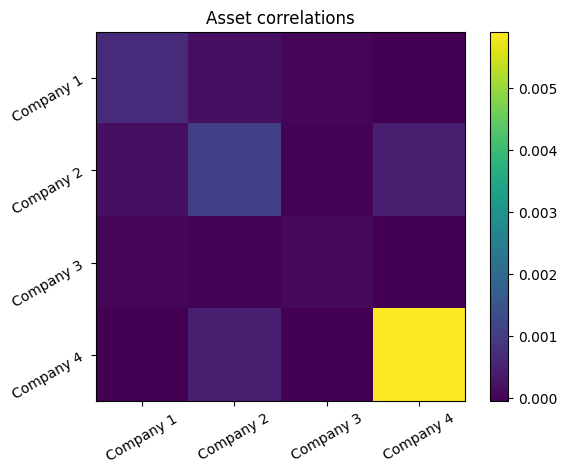

In [5]:
# Visualize mu and sigma
plt.figure()
plt.bar(range(num_assets), mu)
plt.xticks(range(num_assets), stocks, rotation=30)
plt.ylabel('Mean return')

plt.figure()
plt.imshow(sigma)
plt.xticks(range(num_assets), stocks, rotation=30)
plt.yticks(range(num_assets), stocks, rotation=30)
plt.title('Asset correlations')
plt.colorbar()
plt.show()

## Classial Solution
Here we minimize the cost function by seacrhing through all the combinations of $\{x_i\}$. This scales as $2^{n}$.

In [6]:
# Set the risk factor
q = 2.0

In [7]:
def cost_func(x):
    return - np.sum(x * mu) + q * np.sum(np.outer(x, x) * sigma)

def bin_string_to_cost(bin_string):
    x = np.array(list(bin_string), dtype=int)
    return cost_func(x)

In [8]:
costs = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    costs.append(bin_string_to_cost(bin_i))
    print(f"Assets: {bin_i} Cost: {costs[-1]}")

best_assets = np.binary_repr(np.argmin(costs), num_assets)

print(f"\nBest solution: {best_assets} Cost: {min(costs)}")

Assets: 0000 Cost: 0.0
Assets: 0001 Cost: 0.008143299227542165
Assets: 0010 Cost: -0.0019186308869916574
Assets: 0011 Cost: 0.005983352606769094
Assets: 0100 Cost: 0.0008584136138378232
Assets: 0101 Cost: 0.0107490894583868
Assets: 0110 Cost: -0.0010421601657363694
Assets: 0111 Cost: 0.008607199945031193
Assets: 1000 Cost: 0.002998301588287641
Assets: 1001 Cost: 0.010921724815000828
Assets: 1010 Cost: 0.0012762996749757511
Assets: 1011 Cost: 0.008958407167907525
Assets: 1100 Cost: 0.0045824863252258265
Assets: 1101 Cost: 0.014253286168945827
Assets: 1110 Cost: 0.0028785415193314005
Assets: 1111 Cost: 0.012308025629269987

Best solution: 0010 Cost: -0.0019186308869916574


## Quantum Solution

To Solve on a QC, we change to $x_i=(1-z_i)/2$
$$
\begin{split}
C(\{z_i\}) &= \frac{1}{2} \sum_i (\mu_i z_i-\mu_i) + \frac{q}{4}\sum_{ij} (\sigma_{ij} - \sigma_{ij} z_j  - \sigma_{ij} z_i + \sigma_{ij} z_i z_j) \\
&= \frac{1}{4} \sum_i (q\sigma_{ii}-2\mu_i) + \frac{q}{4}\sum_{ij} \sigma_{ij} + \frac{1}{4} \sum_i \left(2 \mu_i  - q\sum_{j} \sigma_{ij} - q\sum_{j} \sigma_{ji} \right) z_i + \frac{q}{4}\sum_{i \ne j} \sigma_{ij} z_i z_j  \\
&= \text{const} + \frac{1}{4}\left(\sum_i  c_i z_i + q\sum_{i \ne j} \sigma_{ij} z_i z_j \right) \\
\end{split}
$$
Now we have the Quantum Hamiltonian:
$$H = \sum_i  c_i Z_i + q\sum_{i \ne j} \sigma_{ij} Z_i Z_j $$

Given an ansatz $|\psi(\theta)\rangle$ we minimize $\langle \psi(\theta)|H|\psi(\theta)\rangle$ to find our solution.

In [9]:
c = 2*mu - q*sigma.sum(0) - q*sigma.sum(1)
const = - 0.5 * mu.sum() + q * 0.25 * (sigma.sum() + sigma.trace())

In [10]:
def construct_hamiltonian(single_coefs, double_coefs):
    """Builds the quantum hamiltonian operator"""
    operators = []
    coefs = []

    for i in range(num_assets):
        op = ['I'] * num_assets
        op[i] = 'Z'
        operators.append(Pauli(''.join(op)))
        coefs.append(single_coefs[i])
        
    for i in range(num_assets-1):
        for j in range(i+1, num_assets):
            op = ['I'] * num_assets
            op[i] = 'Z'
            op[j] = 'Z'
            operators.append(Pauli(''.join(op)))
            coefs.append(double_coefs[i, j] + double_coefs[j, i])

    return SparsePauliOp(operators, coefs)

In [11]:
hamiltonian = construct_hamiltonian(c, q * sigma)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-6.69912727e-03+0.j, -4.20803208e-03+0.j,  3.86389143e-03+0.j,
 -1.75727833e-02+0.j,  7.25771123e-04+0.j,  1.96628974e-04+0.j,
 -2.19876001e-04+0.j,  1.80571074e-05+0.j,  1.74737662e-03+0.j,
 -2.41315734e-04+0.j])

In [12]:
# Check the eigenvalues of the Hamiltonian matches the classical solutions.
assert np.allclose(const + 0.25*np.diag(hamiltonian.to_matrix()), costs)

In [13]:
#def create_ansatz():
    # qc = QuantumCircuit(num_assets)
    
    # for i in range(num_assets):
    #     qc.ry(Parameter(f'theta_{i}'), i)
    # return qc

reps = 10
ansatz = QAOAAnsatz(cost_operator=hamiltonian, reps=reps)

In [14]:
estimator = StatevectorEstimator()

In [15]:
def compute_energy(params, ansatz, cost_history):
    """Return estimate of energy from estimator"""
    pub = (ansatz, [hamiltonian], [params])
    result = estimator.run(pubs=[pub]).result()
    energy = result[0].data.evs[0]

    cost_history.append(energy)
    print(f"Current cost: {energy}")

    return energy

In [16]:
def run_optimization(ansatz, intial_parameters):
    """Minimize the energy of a given ansatz."""

    cost_history = []
    return minimize(compute_energy, intial_parameters, method="cobyla", args=(ansatz, cost_history)), cost_history

In [17]:
def view_results(res, ansatz):
    print(res[0])
    
    sv = Statevector(ansatz.assign_parameters(res[0].x))
    probs = sv.probabilities()

    plt.figure()
    plt.plot(res[1])
    plt.xlabel("Iterations")
    plt.ylabel("Cost")

    plt.figure()
    plt.bar(range(len(probs)), probs)
    plt.axvline(x=int(best_assets, 2), c='k', ls='dashed', label='Classical Sol.')
    plt.legend()
    plt.xlabel("Solution no.")
    plt.ylabel("Probability")

    plt.show()

In [18]:
res = run_optimization(ansatz, 2. * np.pi * np.random.rand(2*reps))

Current cost: -0.005116724169357477
Current cost: -0.005547257128682925
Current cost: -0.0011940927045088453
Current cost: 0.0031614220738408368
Current cost: 0.003168748057813782
Current cost: 0.006277154438714279
Current cost: 0.005748351137379629
Current cost: 0.003963570090899188
Current cost: 0.007841880885258919
Current cost: 0.007512492815625014
Current cost: 0.0071816532775497285
Current cost: -0.0062156853933194225
Current cost: -0.0068624656307018144
Current cost: -0.007585930086381592
Current cost: -0.007317747193840224
Current cost: -0.008182906887189659
Current cost: -0.007676835818151107
Current cost: -0.0075090167088466804
Current cost: -0.008878152099876895
Current cost: -0.008310115500594075
Current cost: -0.008452051108410161
Current cost: -0.0024299699708700876
Current cost: -0.007798702267158544
Current cost: -0.007323939807370351
Current cost: -0.007543854489975256
Current cost: -0.005505367293673165
Current cost: -0.009764661518345983
Current cost: -0.006011638738

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.019031673820773178
       x: [ 3.120e+00  3.170e+00 ... -7.485e-02  2.546e+00]
    nfev: 1000
   maxcv: 0.0


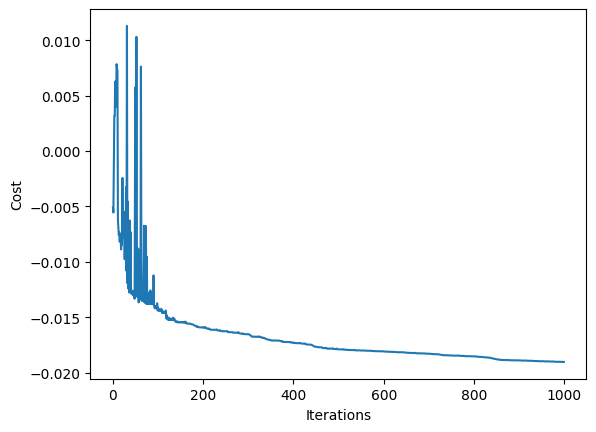

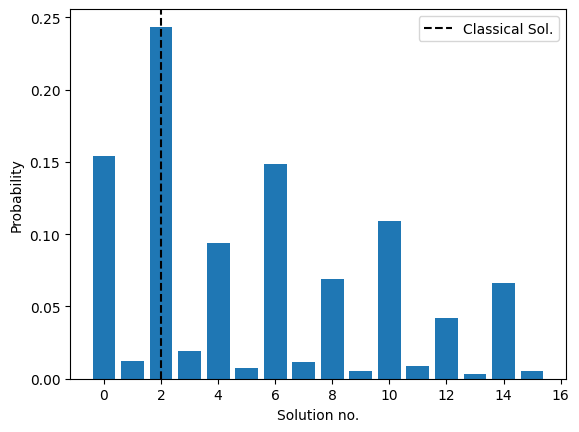

In [19]:
view_results(res, ansatz)

## With constraint

Suppose we have a budget $B \in N$ we must spend, i.e.
$$\sum_i x_i = B$$

In [20]:
budget = 2

## Classical Solution

In [21]:
costs = []
budget_solutions = []

for i in range(2**num_assets):
    bin_i = np.binary_repr(i, num_assets)
    if bin_i.count('1') == budget:
        costs.append(bin_string_to_cost(bin_i))
        budget_solutions.append(bin_i)
        print(f"Assets: {bin_i} Cost: {costs[-1]}")

best_assets = budget_solutions[np.argmin(costs)]
print(f"\nBest solution: {best_assets} Cost: {costs[np.argmin(costs)]}")

Assets: 0011 Cost: 0.005983352606769094
Assets: 0101 Cost: 0.0107490894583868
Assets: 0110 Cost: -0.0010421601657363694
Assets: 1001 Cost: 0.010921724815000828
Assets: 1010 Cost: 0.0012762996749757511
Assets: 1100 Cost: 0.0045824863252258265

Best solution: 0110 Cost: -0.0010421601657363694


## Quantum Solution
We can force our quantum algorithm to find such solution by introducing a penalty term in the cost function
$$
\begin{split}
C_{\text{penalty}} &= \lambda \left(\sum_i x_i - B\right)^2 = \lambda \left( \tilde n - \frac{1}{2}\sum_i z_i\right)^2 \\
&= \lambda \tilde n ^2 + \frac{\lambda}{4}\sum_{ij} z_iz_j - \lambda \tilde n \sum_i z_i  \\
\end{split}
$$
where $\tilde n = \frac{n - 2B}{2}.$

Thus our Hamiltonian is now

$$H = \sum_i  \left(c_i - \lambda \tilde n \right) Z_i + \sum_{i \ne j} \left(q\sigma_{ij}  + \frac{\lambda}{4} \right) Z_i Z_j  $$


In [22]:
n_tidle = (num_assets - 2*budget) / 2.

lambda_param = 1.0

hamiltonian = construct_hamiltonian(c - lambda_param*n_tidle, q * sigma + lambda_param / 4.)
hamiltonian

SparsePauliOp(['ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[-0.00669913+0.j, -0.00420803+0.j,  0.00386389+0.j, -0.01757278+0.j,
  0.50072577+0.j,  0.50019663+0.j,  0.49978012+0.j,  0.50001806+0.j,
  0.50174738+0.j,  0.49975868+0.j])

In [23]:
res_qaoa = run_optimization(ansatz, 2 * np.pi * np.random.rand(2*reps))

Current cost: 0.020504381016210726
Current cost: 0.04329286414182979
Current cost: 0.03179174707286167
Current cost: 0.02835241438991092
Current cost: 0.001699661603272595
Current cost: 0.01362880018253758
Current cost: 0.04619352379095812
Current cost: 0.029908603421848756
Current cost: 0.029785624867667164
Current cost: 0.031927904253511066
Current cost: 0.02200302612021502
Current cost: 0.005316774741948613
Current cost: 0.0011182296343766503
Current cost: -0.00026913341497995097
Current cost: -9.25544409593939e-05
Current cost: 0.0023503970256702703
Current cost: -0.0005677055792771097
Current cost: -0.002748390745450255
Current cost: -0.0019744333512421615
Current cost: -0.003433867185742307
Current cost: -0.002826092090363062
Current cost: -0.022156458293918966
Current cost: 0.01926566432125113
Current cost: -0.0020225942823557832
Current cost: 0.0037079534754385765
Current cost: 0.0013416454650563036
Current cost: -0.002511579892119183
Current cost: -0.02198163262020858
Current 

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -0.08373766642494496
       x: [ 4.695e+00  1.598e+00 ...  1.116e+00  4.799e+00]
    nfev: 1000
   maxcv: 0.0


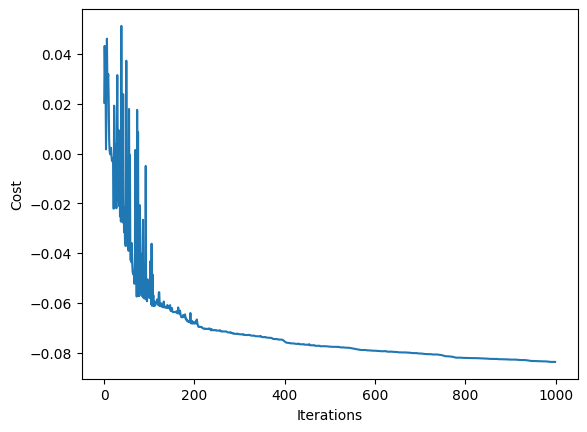

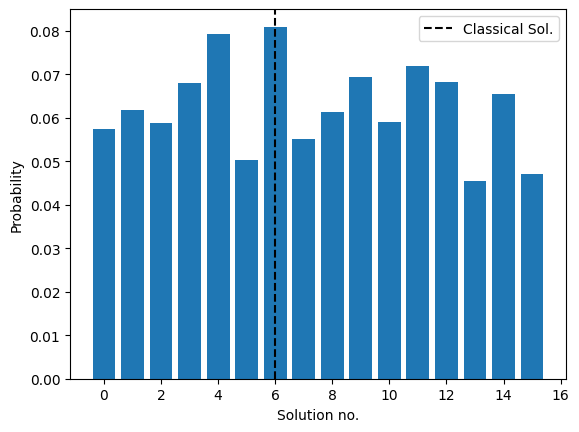

In [24]:
view_results(res_qaoa, ansatz)